In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/te2mp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3607).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3961).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3958).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3643).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4088).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3679).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3506).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4161).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4121).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3534).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3596).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3460).jpg
/kag

In [8]:
from tensorflow.keras.applications import VGG19, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D, BatchNormalization,Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import cv2 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pprint
from collections import deque
import copy
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-11-01 19:10:16.309739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762024216.525845      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762024216.591312      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
base_path = "/kaggle/input/chest-xray-covid19-pneumonia"
categories = ['NORMAL', 'COVID19', 'PNEUMONIA']
image_size = (224,224)

In [10]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [11]:
# Load training data
train_path = os.path.join(base_path, 'Data', 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA...


In [12]:
# Load test data
test_path = os.path.join(base_path, 'Data', 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA...


In [13]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [14]:
from sklearn.utils import shuffle

# Shuffle training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Shuffle test data
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

In [15]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [16]:
label_mapping = {'COVID19': 0, 'PNEUMONIA': 1,'NORMAL': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [17]:
train_images.shape

(5144, 224, 224, 3)

In [18]:
test_images.shape

(1288, 224, 224, 3)

# optimizing COVIDet's hyperparameters using ant colony 

In [28]:
search_space_ranges = {
    'learning_rate': [1e-5, 1e-3, 1e-5], 
    'batch_size':    [8, 64, 8],          
    'conv_filters':  [32, 128, 16],    
    'n_conv_layers': [4, 10, 2],        
    'dense_units_1': [64, 256, 64],    
    'dense_units_2': [32, 128, 32],     
    'dropout_rate':  [0, 0.7, 0.1]      
}
img_shape = (224, 224, 3)
num_classes = 3

In [14]:
# Converting Search Space Ranges into discrete numbers
search_space_discrete = {}

# Handle integer ranges
int_keys = ['batch_size', 'conv_filters', 'n_conv_layers', 'dense_units_1', 'dense_units_2']
for key in int_keys:
    start, end, step = search_space_ranges[key]
    search_space_discrete[key] = list(range(start, end + 1, step))

# Handle float ranges
float_keys = ['learning_rate', 'dropout_rate']
for key in float_keys:
    start, end, step = search_space_ranges[key]
    num_steps = int(round((end - start) / step)) + 1
    search_space_discrete[key] = [round(v, 6) for v in np.linspace(start, end, num_steps)]


print("Generated Discrete Search Space (for ACO):")
pprint.pprint(search_space_discrete)
print("-" * 40)

Generated Discrete Search Space (for ACO):
{'batch_size': [8, 16, 24, 32, 40, 48, 56, 64],
 'conv_filters': [32, 48, 64, 80, 96, 112, 128],
 'dense_units_1': [64, 128, 192, 256],
 'dense_units_2': [32, 64, 96, 128],
 'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
 'learning_rate': [1e-05,
                   2e-05,
                   3e-05,
                   4e-05,
                   5e-05,
                   6e-05,
                   7e-05,
                   8e-05,
                   9e-05,
                   0.0001,
                   0.00011,
                   0.00012,
                   0.00013,
                   0.00014,
                   0.00015,
                   0.00016,
                   0.00017,
                   0.00018,
                   0.00019,
                   0.0002,
                   0.00021,
                   0.00022,
                   0.00023,
                   0.00024,
                   0.00025,
                   0.00026,
                 

In [15]:
def build_model_for_tuning(params):
    inputs = Input(shape=img_shape)

    x = Conv2D(int(params['conv_filters']), (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for i in range(int(params['n_conv_layers'])):
        x = Conv2D(int(params['conv_filters']), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(int(params['dense_units_1']), activation='relu')(x)
    x = Dropout(params['dropout_rate'])(x)
    x = Dense(int(params['dense_units_2']), activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x) 

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=params['learning_rate'])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

In [16]:
def build_and_evaluate(params):
    model = build_model_for_tuning(params)
    
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        batch_size=int(params['batch_size']),
        epochs=epochs, 
        validation_split=0.15, 
        verbose=0 
    )
    # 3. Get the fitness score
    fitness = 0.0
    if history.history['val_accuracy']: 
        fitness = max(history.history['val_accuracy'])
        
    print(f"Params: {params} --> Fitness (Val Acc): {fitness:.4f}")

    del model
    tf.keras.backend.clear_session()
    
    return fitness, None 

In [17]:
pheromones = {}
for key, values in search_space_discrete.items():
    pheromones[key] = {val: 1.0 for val in values}

param_keys = list(search_space_discrete.keys())

# ACO parameters
n_ants = 5
epochs = 5
n_iterations = 5
evaporation_rate = 0.1

best_solution = None
best_fitness = 0.0

print("--- Starting ACO Hyperparameter Optimization ---")

for iteration in range(n_iterations):
    print(f"\n--- Iteration {iteration + 1}/{n_iterations} ---")
    
    ant_solutions_this_iter = [] 
    
    for ant in range(n_ants):
        print(f"\tAnt {ant+1}/{n_ants} is building a solution...")
        current_solution = {}
        
        for key in param_keys:
            choices = list(pheromones[key].keys())
            scores = list(pheromones[key].values())
            total_pheromone = sum(scores)
            
            if total_pheromone == 0:
                probabilities = [1.0 / len(choices)] * len(choices)
            else:
                probabilities = [s / total_pheromone for s in scores]
            
            chosen_value = random.choices(choices, weights=probabilities, k=1)[0]
            current_solution[key] = chosen_value
        
        fitness, _ = build_and_evaluate(current_solution)
        
        if fitness > 0:
            print(f"\t-> Ant {ant+1} Result: Fitness: {fitness:.4f}")
        else:
            print(f"\t-> Ant {ant+1} Result: Training failed or produced 0 fitness.")

        ant_solutions_this_iter.append((current_solution, fitness))

        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = current_solution
            print(f"\t*** New Global Best Solution Found! Fitness: {fitness:.4f} ***")

    if ant_solutions_this_iter:
        best_iter_fitness = max([f for _, f in ant_solutions_this_iter])
        print(f"\n\t== Iteration {iteration + 1} Summary ==")
        print(f"\t   Best Fitness this Iteration: {best_iter_fitness:.4f}")
        print(f"\t   Global Best Fitness So Far:  {best_fitness:.4f}")
    else:
        print(f"\n\t== Iteration {iteration + 1} Summary ==")
        print("\t   No successful solutions in this iteration.")
    # phermone update   
    # Evaporation
    for key, values in pheromones.items():
        for val in values:
            pheromones[key][val] *= (1.0 - evaporation_rate)
            
    # Deposit (on the best ant of this iteration*)
    ant_solutions_this_iter.sort(key=lambda x: x[1], reverse=True)
    if ant_solutions_this_iter and ant_solutions_this_iter[0][1] > 0:
        best_ant_solution, best_ant_fitness = ant_solutions_this_iter[0]
        for key, value in best_ant_solution.items():
            pheromones[key][value] += best_ant_fitness
    else:
        print("\n\tNo successful solutions in this iteration to deposit pheromone.")

print("\n--- ACO Finished ---")
print(f"Best solution found: {best_solution}")
print(f"Best fitness (validation accuracy): {best_fitness:.4f}")

--- Starting ACO Hyperparameter Optimization ---

--- Iteration 1/5 ---
	Ant 1/5 is building a solution...


I0000 00:00:1762012242.067738      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762012242.068563      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1762012259.776171     107 service.cc:148] XLA service 0x7c7fdc00e370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762012259.777322     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762012259.777345     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762012260.718057     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762012272.051670     107 device_compiler.h:188] Compiled clust

Params: {'batch_size': 64, 'conv_filters': 64, 'n_conv_layers': 6, 'dense_units_1': 128, 'dense_units_2': 64, 'learning_rate': 0.00031, 'dropout_rate': 0.2} --> Fitness (Val Acc): 0.7435
	-> Ant 1 Result: Fitness: 0.7435
	*** New Global Best Solution Found! Fitness: 0.7435 ***
	Ant 2/5 is building a solution...
Params: {'batch_size': 64, 'conv_filters': 96, 'n_conv_layers': 6, 'dense_units_1': 256, 'dense_units_2': 96, 'learning_rate': 0.00047, 'dropout_rate': 0.3} --> Fitness (Val Acc): 0.7435
	-> Ant 2 Result: Fitness: 0.7435
	Ant 3/5 is building a solution...
Params: {'batch_size': 40, 'conv_filters': 80, 'n_conv_layers': 4, 'dense_units_1': 192, 'dense_units_2': 96, 'learning_rate': 0.00011, 'dropout_rate': 0.2} --> Fitness (Val Acc): 0.9417
	-> Ant 3 Result: Fitness: 0.9417
	*** New Global Best Solution Found! Fitness: 0.9417 ***
	Ant 4/5 is building a solution...
Params: {'batch_size': 56, 'conv_filters': 32, 'n_conv_layers': 8, 'dense_units_1': 64, 'dense_units_2': 32, 'learning

In [18]:
print("\n--- Training Final Model with Best Parameters ---")
print(f"Using best parameters: {best_solution}")

final_model_epochs = 50 
final_model = build_model_for_tuning(best_solution)
final_batch_size = int(best_solution['batch_size'])

print(f"Training final model for {final_model_epochs} epochs...")

final_history = final_model.fit(
    train_images, 
    train_labels_one_hot, 
    batch_size=final_batch_size,
    epochs=final_model_epochs,
    verbose=1,
    validation_split=0.15
)

print("\n--- Final Model Training Complete ---")
print(final_model.summary())


--- Training Final Model with Best Parameters ---
Using best parameters: {'batch_size': 40, 'conv_filters': 128, 'n_conv_layers': 4, 'dense_units_1': 64, 'dense_units_2': 96, 'learning_rate': 0.00077, 'dropout_rate': 0.2}
Training final model for 50 epochs...
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - accuracy: 0.8075 - loss: 0.3514 - precision: 0.8169 - recall: 0.7927 - val_accuracy: 0.1075 - val_loss: 0.9404 - val_precision: 0.1075 - val_recall: 0.1075
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.9335 - loss: 0.1274 - precision: 0.9366 - recall: 0.9303 - val_accuracy: 0.0894 - val_loss: 2.4766 - val_precision: 0.0894 - val_recall: 0.0894
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - accuracy: 0.9424 - loss: 0.1069 - precision: 0.9453 - recall: 0.9413 - val_accuracy: 0.3484 - val_loss: 1.2017 - val_precision: 0.3468 - val_recall: 0.3459
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9568 - loss: 0.0914 - precision

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,010,891 (11.49 MB)

 Trainable params: 1,003,203 (3.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 2,006,408 (7.65 MB)

None


In [19]:
print("\n--- Evaluating Model on Test Data ---")

# Unpack all four metrics that the model is returning
test_loss, test_accuracy, test_precision, test_recall = final_model.evaluate(
    test_images, 
    test_labels_one_hot,
    batch_size=final_batch_size,
    verbose=1
)

print("\n--- Test Results ---")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")


--- Evaluating Model on Test Data ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9512 - loss: 0.1639 - precision: 0.9513 - recall: 0.9512

--- Test Results ---
Test Loss:      0.1590
Test Accuracy:  95.26%
Test Precision: 0.9534
Test Recall:    0.9526


In [26]:
# --- This is the code from your previous step, now corrected ---

y_pred_probs = final_model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# FIX: Use your one-hot encoded labels to get integer labels
# This will create an array of integers [0, 1, 2] that matches y_pred
y_true = np.argmax(test_labels_one_hot, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


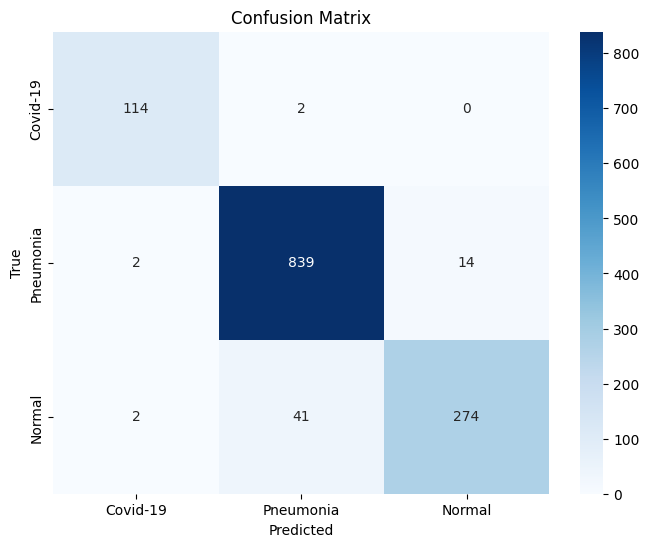

In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC curve plot saved as 'roc_curve_plot.png'


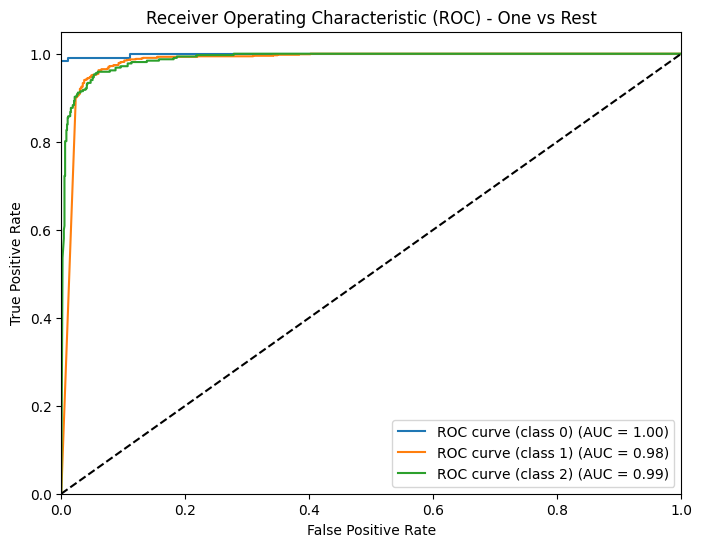

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# --- 2. Calculate ROC curve and AUC for each class ---
for i in range(num_classes):
    # FIX 1: Use your 2D 'test_labels_one_hot' variable here
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- 3. Plot all ROC curves ---
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # FIX 2: Corrected f-string for the label
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc="lower right")

print("ROC curve plot saved as 'roc_curve_plot.png'")

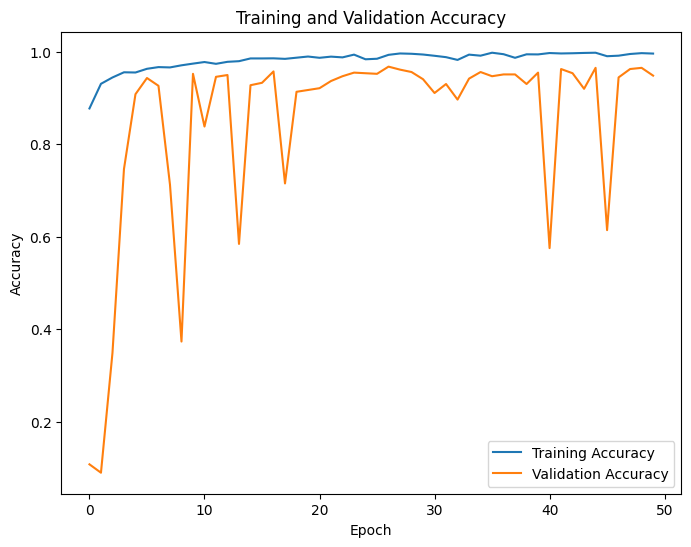

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')

# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

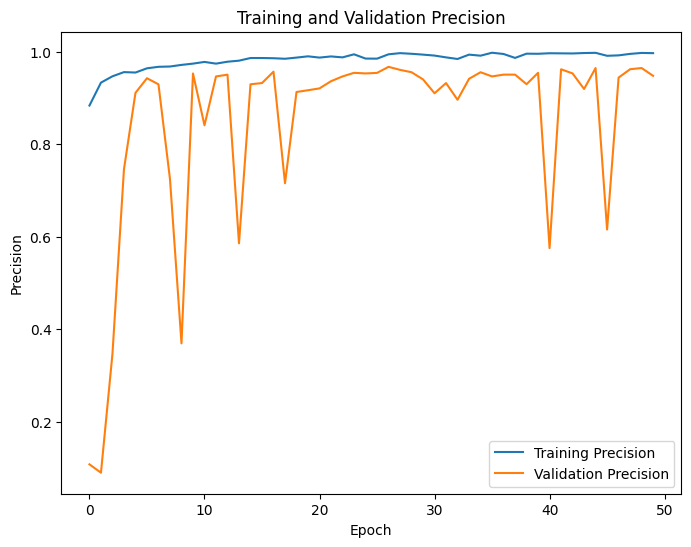

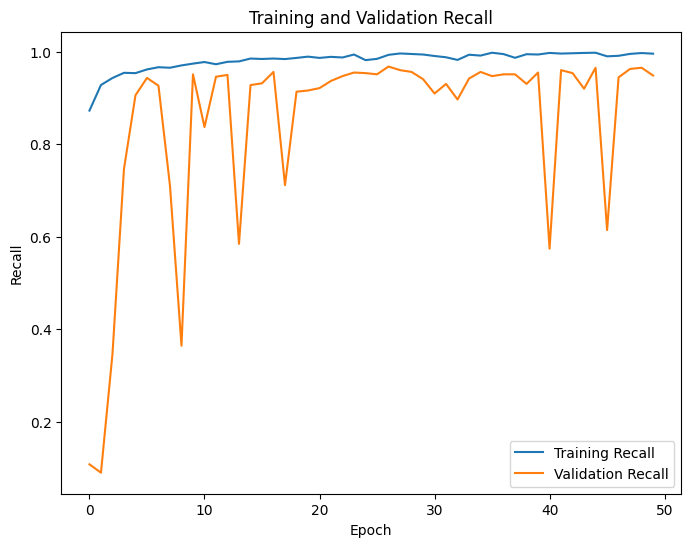

In [39]:
import matplotlib.pyplot as plt

# Assume 'final_history' and 'history_keys' exist
history_keys = final_history.history.keys()

if 'precision' in history_keys and 'val_precision' in history_keys:
    # Plot Precision
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['precision'], label='Training Precision')
    plt.plot(final_history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    # By not calling plt.clf(), this plot will be displayed
    # when the cell finishes running.

if 'recall' in history_keys and 'val_recall' in history_keys:
    # Plot Recall
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['recall'], label='Training Recall')
    plt.plot(final_history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    # This second plot will also be displayed.

# optimizing COVIDet's hyperparameters using PSO

In [54]:
def build_model_for_tuning(params):
    """Builds a Keras model from a dictionary of hyperparameters."""
    model = Sequential()
    model.add(Input(shape=img_shape))

    # Add a variable number of convolutional layers
    for _ in range(params['n_conv_layers']):
        model.add(Conv2D(params['conv_filters'], (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Add variable dense layers
    model.add(Dense(params['dense_units_1'], activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(params['dense_units_2'], activation='relu'))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with all requested metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy', # Correct for one-hot labels
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

In [55]:
bounds = [
    (1e-5, 1e-3, 'log'),       # learning_rate
    (8, 64, 'int'),            # batch_size
    (32, 128, 'int'),          # conv_filters
    (1, 4, 'int'),             # n_conv_layers (Changed min from 4 to 1)
    (64, 256, 'int'),          # dense_units_1
    (32, 128, 'int'),          # dense_units_2
    (0.0, 0.7, 'linear')       # dropout_rate
]
epochs_per_trial = 5

In [56]:
class Particle:
    """Class to represent a single particle in the swarm."""
    def __init__(self, bounds):
        self.pos = []
        self.vel = []
        for lo, hi, t in bounds:
            if t == 'log':
                val = 10**np.random.uniform(np.log10(lo), np.log10(hi))
            elif t == 'int':
                val = np.random.randint(lo, hi + 1)
            else:
                val = np.random.uniform(lo, hi)
            self.pos.append(val)
            self.vel.append(0.0)
        self.best_pos = self.pos.copy()
        self.best_score = -1e9  # Initialize with a very low score

In [57]:
def enforce(idx, val):
    """Enforce the bounds for a given parameter."""
    lo, hi, t = bounds[idx]
    if t == 'int':
        v = int(round(val))
        v = max(lo, min(hi, v))
        return v
    if t == 'log' or t == 'linear':
        v = float(val)
        v = max(lo, min(hi, v))
        return v
    return val

In [58]:
def eval_particle(particle, sample_train_imgs, sample_train_labels):
    params = {
        'learning_rate': particle.pos[0],
        'batch_size':    int(round(particle.pos[1])),
        'conv_filters':  int(round(particle.pos[2])),
        'n_conv_layers': int(round(particle.pos[3])),
        'dense_units_1': int(round(particle.pos[4])),
        'dense_units_2': int(round(particle.pos[5])),
        'dropout_rate':  particle.pos[6]
    }
    batch = int(params['batch_size'])
    
    # Build the model using the provided function
    m = build_model_for_tuning(params)
    
    try:
        history = m.fit(
            sample_train_imgs, sample_train_labels,
            batch_size=batch,
            epochs=epochs_per_trial, # Use the fixed epochs
            validation_split=0.15,   # Use a split of the *sample* data
            verbose=0
        )
        score = 0.0
        if 'val_accuracy' in history.history and history.history['val_accuracy']:
            score = max(history.history['val_accuracy'])
            
    except Exception as e:
        print(f"Error during training particle: {e}")
        score = 0.0 # Give a 0 score if training fails

    del m
    tf.keras.backend.clear_session()

    return score

In [59]:
num_particles = 5
max_iter = 5
w, c1, c2 = 0.5, 1.0, 1.0

swarm = [Particle(bounds) for _ in range(num_particles)]
gbest_pos = None
gbest_score = -1e9
print("--- Starting PSO Hyperparameter Optimization ---")

for it in range(max_iter):
    print(f"\n--- PSO Iteration {it + 1}/{max_iter} ---")

    for i, p in enumerate(swarm):
        # Evaluate the particle
        score = eval_particle(p, train_images, train_labels_one_hot)
        
        print(f'\tParticle {i+1}/{num_particles} -> val_accuracy {score:.4f}')
        # Update personal best (pbest)
        if score > p.best_score:
            p.best_score = score
            p.best_pos = p.pos.copy()

        # Update global best (gbest)
        if score > gbest_score:
            gbest_score = score
            gbest_pos = p.pos.copy()
            print(f"\t*** New Global Best Solution Found! Fitness: {gbest_score:.4f} ***")

    # Update velocities and positions for all particles
    if gbest_pos is not None: # Only update if a gbest has been found
        for p in swarm:
            for j in range(len(p.pos)):
                r1, r2 = np.random.rand(), np.random.rand()
                cognitive = c1 * r1 * (p.best_pos[j] - p.pos[j])
                social = c2 * r2 * (gbest_pos[j] - p.pos[j])
                
                p.vel[j] = w * p.vel[j] + cognitive + social
                p.pos[j] = enforce(j, p.pos[j] + p.vel[j])

print("\n--- PSO Finished ---")
print(f"PSO best score: {gbest_score:.4f}")

--- Starting PSO Hyperparameter Optimization ---

--- PSO Iteration 1/5 ---
	Particle 1/5 -> val_accuracy 0.9456
	*** New Global Best Solution Found! Fitness: 0.9456 ***
	Particle 2/5 -> val_accuracy 0.9326
	Particle 3/5 -> val_accuracy 0.9080
	Particle 4/5 -> val_accuracy 0.9508
	*** New Global Best Solution Found! Fitness: 0.9508 ***
	Particle 5/5 -> val_accuracy 0.9404

--- PSO Iteration 2/5 ---
	Particle 1/5 -> val_accuracy 0.9495
	Particle 2/5 -> val_accuracy 0.9482
	Particle 3/5 -> val_accuracy 0.9391
	Particle 4/5 -> val_accuracy 0.9417
	Particle 5/5 -> val_accuracy 0.9443

--- PSO Iteration 3/5 ---
	Particle 1/5 -> val_accuracy 0.9495
	Particle 2/5 -> val_accuracy 0.9430
	Particle 3/5 -> val_accuracy 0.9339
	Particle 4/5 -> val_accuracy 0.9404
	Particle 5/5 -> val_accuracy 0.9482

--- PSO Iteration 4/5 ---
	Particle 1/5 -> val_accuracy 0.9482
	Particle 2/5 -> val_accuracy 0.9534
	*** New Global Best Solution Found! Fitness: 0.9534 ***
	Particle 3/5 -> val_accuracy 0.9430
	Parti

In [60]:
best_solution = None
if gbest_pos is not None:
    best_solution = {
        'learning_rate': gbest_pos[0],
        'batch_size':    int(round(gbest_pos[1])),
        'conv_filters':  int(round(gbest_pos[2])),
        'n_conv_layers': int(round(gbest_pos[3])),
        'dense_units_1': int(round(gbest_pos[4])),
        'dense_units_2': int(round(gbest_pos[5])),
        'dropout_rate':  gbest_pos[6]
    }
    print("\nBest parameters found by PSO:")
    print(best_solution)
else:
    print("PSO did not find a valid solution. Skipping final training.")


Best parameters found by PSO:
{'learning_rate': 0.0006746533137620478, 'batch_size': 63, 'conv_filters': 55, 'n_conv_layers': 4, 'dense_units_1': 119, 'dense_units_2': 94, 'dropout_rate': 0.48466486343695875}


In [61]:
print("\n--- Training Final Model with Best Parameters ---")
final_model_epochs = 50  
final_model = build_model_for_tuning(best_solution)
final_batch_size = int(best_solution['batch_size'])

print(f"Training final model for {final_model_epochs} epochs...")

final_history = final_model.fit(
    train_images,  # Use the *full* training data
    train_labels_one_hot, 
    batch_size=final_batch_size,
    epochs=final_model_epochs,
    verbose=1,
    validation_split=0.15 # Use validation split on the full training data
)

print("\n--- Final Model Training Complete ---")
print(final_model.summary())


--- Training Final Model with Best Parameters ---
Training final model for 50 epochs...
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.7088 - loss: 0.7164 - precision: 0.7160 - recall: 0.6300 - val_accuracy: 0.9132 - val_loss: 0.2386 - val_precision: 0.9171 - val_recall: 0.9028
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9088 - loss: 0.2905 - precision: 0.9164 - recall: 0.8979 - val_accuracy: 0.9197 - val_loss: 0.2027 - val_precision: 0.9219 - val_recall: 0.9171
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9117 - loss: 0.2574 - precision: 0.9168 - recall: 0.9055 - val_accuracy: 0.9417 - val_loss: 0.1851 - val_precision: 0.9425 - val_recall: 0.9339
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9241 - loss: 0.2073 - precision: 0.9269 - recall: 0.9195 - val_accuracy: 0.9339 - val_loss: 0.1863 - val_precision: 0.9364 - val_recall: 0.9339
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9330

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 55)   │         1,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 55)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 55)   │        27,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 55)     │        27,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 55)     │        27,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10780)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 119)            │     1,282,939 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 119)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 94)             │        11,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,654 (15.77 MB)

 Trainable params: 1,377,884 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,755,770 (10.51 MB)

None


In [62]:
test_loss, test_accuracy, test_precision, test_recall = final_model.evaluate(
    test_images, 
    test_labels_one_hot,
    batch_size=final_batch_size,
    verbose=1
)

print("\n--- Test Results ---")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9553 - loss: 0.4130 - precision: 0.9553 - recall: 0.9553

--- Test Results ---
Test Loss:     0.4118
Test Accuracy: 95.26%
Test Precision: 0.9526
Test Recall:    0.9526



--- Generating Final Model Plots ---


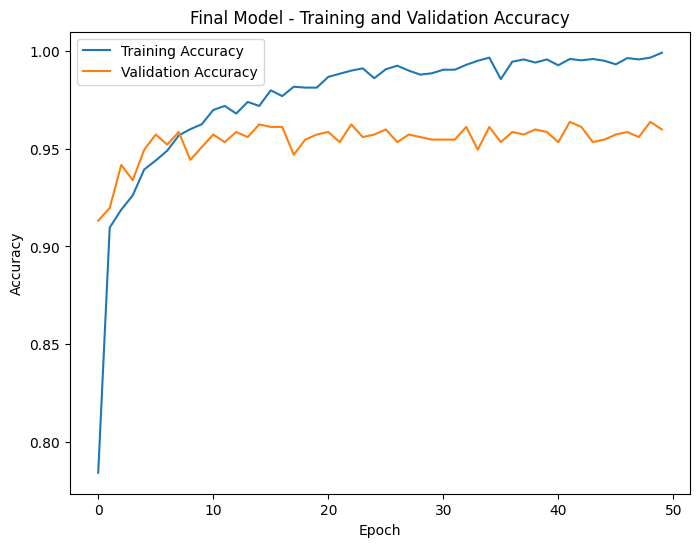

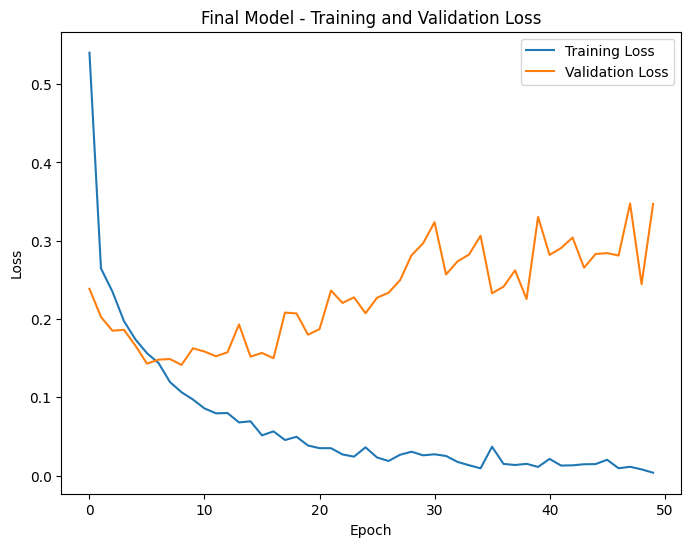

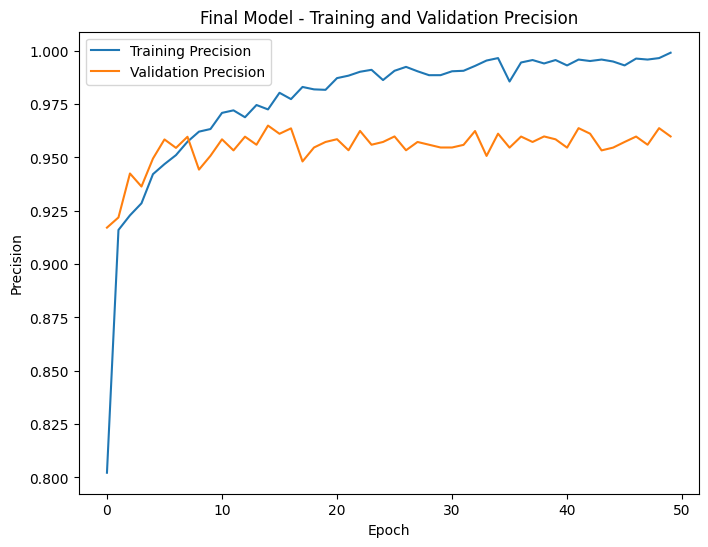

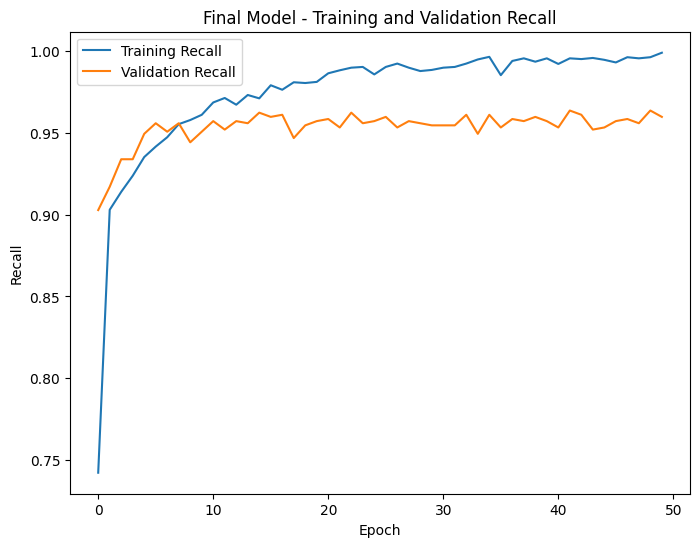

In [64]:
import matplotlib.pyplot as plt

print("\n--- Generating Final Model Plots ---")
best_history = final_history # Use the history from the final model

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot Precision
if 'precision' in best_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['precision'], label='Training Precision')
    plt.plot(best_history.history['val_precision'], label='Validation Precision')
    plt.title('Final Model - Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    # plt.clf()  <-- REMOVED

# Plot Recall
if 'recall' in best_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(best_history.history['recall'], label='Training Recall')
    plt.plot(best_history.history['val_recall'], label='Validation Recall')
    plt.title('Final Model - Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    # plt.clf()  <-- REMOVED

# All plots will now display in the output

# optimizing COVIDet's hyperparameters using Simulated Annealing

In [38]:
SPACE = {
    "LEARNING_RATE": {
        "type": "float", "min": 1e-5, "max": 1e-2, "log": True
    },
    "BATCH_SIZE": {
        "type": "int", "min": 8, "max": 64, "step": 8
    },
    "CONV_FILTERS": {
        "type": "int", "min": 32, "max": 128, "step": 16
    },
    "N_CONV_LAYERS": {
        "type": "int", "min": 4, "max": 10, "step": 2
    },
    "DENSE_UNITS_1": {
        "type": "int", "min": 64, "max": 256, "step": 64
    },
    "DENSE_UNITS_2": {
        "type": "int", "min": 32, "max": 128, "step": 32
    },
    "DROPOUT_RATE": {
        "type": "float", "min": 0.0, "max": 0.7, "step": 0.1
    }
}

START = {
    "LEARNING_RATE": 1e-4,
    "BATCH_SIZE": 16,
    "CONV_FILTERS": 32,
    "N_CONV_LAYERS": 4,
    "DENSE_UNITS_1": 64,
    "DENSE_UNITS_2": 32,
    "DROPOUT_RATE": 0.1
}

In [39]:
def _clip_round(name, val):
    """Clip and round value to valid range"""
    spec = SPACE[name]
    
    if spec["type"] == "int":
        step = spec.get("step", 1)
        v = int(round(val / step) * step) # Snap to grid
        return int(max(spec["min"], min(spec["max"], v)))
    
    if spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            # Ensure val is within bounds before log
            safe_val = max(spec["min"], min(spec["max"], float(val)))
            log_val = np.log10(safe_val)
            log_val = max(log_min, min(log_max, log_val))
            v = 10 ** log_val
        else:
            v = float(max(spec["min"], min(spec["max"], float(val))))
        
        step = spec.get("step", None)
        if step is not None and step > 0:
            v = round(v / step) * step
            v = float(max(spec["min"], min(spec["max"], v)))
        else:
            precision = spec.get("precision", 6)
            v = round(v, precision)
        
        return v

In [40]:
def _random_neighbor(cfg):
    """Generate random neighbor by modifying one parameter"""
    name = random.choice(list(SPACE.keys()))
    spec = SPACE[name]
    new_cfg = cfg.copy()
    
    if spec["type"] == "int":
        step = spec["step"]
        delta = random.choice([-step, step])
        new_cfg[name] = _clip_round(name, cfg[name] + delta)
    
    elif spec["type"] == "float":
        if spec.get("log", False):
            log_min = np.log10(spec["min"])
            log_max = np.log10(spec["max"])
            log_val = np.log10(cfg[name])
            step_size = (log_max - log_min) * 0.1  # Perturb by 10% of log range
            delta = random.choice([-step_size, step_size])
            new_val = 10 ** (log_val + delta)
        else:
            step = spec.get("step", (spec['max'] - spec['min']) * 0.1) # 10% of range
            delta = random.choice([-step, step])
            new_val = cfg[name] + delta
        
        new_cfg[name] = _clip_round(name, new_val)
    
    return new_cfg, name

In [41]:
def evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs):
    print("EVALUATING MODEL WITH PARAMETERS:")
    pprint.pprint(candidate)
    
    try:
        def build_covidet_model(params):
            inputs = Input(shape=img_shape)

            x = Conv2D(int(params['CONV_FILTERS']), (3, 3), padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

            for i in range(int(params['N_CONV_LAYERS'])):
                x = Conv2D(int(params['CONV_FILTERS']), (3, 3), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

            x = Flatten()(x)
            x = Dense(int(params['DENSE_UNITS_1']), activation='relu')(x)
            x = Dropout(params['DROPOUT_RATE'])(x)
            x = Dense(int(params['DENSE_UNITS_2']), activation='relu')(x)
            outputs = Dense(num_classes, activation='softmax')(x) 

            model = Model(inputs=inputs, outputs=outputs)
            return model

        model = build_covidet_model(candidate)
        
        model.compile(optimizer=Adam(learning_rate=candidate['LEARNING_RATE']), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy',
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall')])

        print("\nTraining model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=candidate['BATCH_SIZE'],
            epochs=epochs,
            verbose=0 
        )

        val_accuracy = 0.0  # Default if training fails
        train_accuracy = 0.0 # Default
        
        if 'val_accuracy' in history.history and history.history['val_accuracy']:
            # Find the epoch with the best validation accuracy
            best_epoch_index = np.argmax(history.history['val_accuracy'])
            val_accuracy = history.history['val_accuracy'][best_epoch_index]
            
            # Get the training accuracy from that *same* epoch
            if 'accuracy' in history.history and len(history.history['accuracy']) > best_epoch_index:
                train_accuracy = history.history['accuracy'][best_epoch_index]
                
        print(f"\nBest Run Metrics: Val Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}")

        
        return val_accuracy, history, model
    
    except Exception as e:
        print(f"\nError during training: {e}")
        tf.keras.backend.clear_session()
        return 0.0, None, None

In [42]:
def simulated_annealing(X_train, y_train, X_val, y_val, epochs, iters=20, T0=1.0, alpha=0.95):
    print("STARTING SIMULATED ANNEALING")
    
    current_solution = START.copy()
    
    print("\nInitializing with starting parameters:")
    for key, val in current_solution.items():
        print(f"  {key}: {val}")
        
    current_accuracy, _, initial_model = evaluate_parameters(current_solution, X_train, y_train, X_val, y_val, epochs)
    
    if initial_model:
        del initial_model
        tf.keras.backend.clear_session()
    
    best_solution = current_solution.copy()
    best_accuracy = current_accuracy
    
    T = T0
    history_log = [best_accuracy] # Log initial accuracy
    
    print("\n--- STARTING SA ITERATIONS ---")
    
    for iteration in range(iters):
        print("-" * 40)
        print(f"ITERATION {iteration + 1}/{iters}")
        print(f"Temperature: {T:.4f}")
        print(f"Current Best Accuracy: {best_accuracy:.4f}")
        
        candidate, param_changed = _random_neighbor(current_solution)
        
        print(f"\nChanging parameter: {param_changed}")
        print(f"  Old value: {current_solution[param_changed]}")
        print(f"  New value: {candidate[param_changed]}")
        
        candidate_accuracy, _, candidate_model = evaluate_parameters(candidate, X_train, y_train, X_val, y_val, epochs)
        
        if candidate_model:
            del candidate_model
            tf.keras.backend.clear_session()
        
        delta = candidate_accuracy - current_accuracy
        
        print(f"\nAccuracy Change (delta): {delta:.4f}")
        print(f"  Previous Accuracy: {current_accuracy:.4f}")
        print(f"  Candidate Accuracy: {candidate_accuracy:.4f}")
        
        if delta > 0:
            print(f"ACCEPTED: Better accuracy found!")
            current_solution = candidate
            current_accuracy = candidate_accuracy
        else:
            acceptance_prob = np.exp(delta / T) if T > 0 else 0
            rand_val = np.random.rand()
            
            print(f"  Worse solution. Acceptance probability: {acceptance_prob:.4f}")
            print(f"  Random value: {rand_val:.4f}")
            
            if rand_val < acceptance_prob:
                print(f"  ACCEPTED: Accepted worse solution probabilistically!")
                current_solution = candidate
                current_accuracy = candidate_accuracy
            else:
                print(f"  REJECTED: Worse solution rejected.")
        
        if current_accuracy > best_accuracy:
            print(f"\n*** NEW BEST SOLUTION FOUND! ***")
            best_solution = current_solution.copy()
            best_accuracy = current_accuracy
        
        T *= alpha
        history_log.append(best_accuracy) # Log the best accuracy so far
        
        print(f"\nNew Temperature: {T:.4f}")
    
    print("\n--- SIMULATED ANNEALING COMPLETED ---")
    print("\nBest Parameters Found:")
    pprint.pprint(best_solution)
    print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
    
    return best_solution, best_accuracy, history_log

In [43]:
best_params, best_acc, sa_history = simulated_annealing(
    train_images, train_labels_one_hot, 
    test_images, test_labels_one_hot, # Using test as validation for this search
    epochs=5,    # Epochs per trial
    iters=5,      # Total number of models to try
    T0=1.0,       # Initial temperature
    alpha=0.95    # Cooling rate
)

STARTING SIMULATED ANNEALING

Initializing with starting parameters:
  LEARNING_RATE: 0.0001
  BATCH_SIZE: 16
  CONV_FILTERS: 32
  N_CONV_LAYERS: 4
  DENSE_UNITS_1: 64
  DENSE_UNITS_2: 32
  DROPOUT_RATE: 0.1
EVALUATING MODEL WITH PARAMETERS:
{'BATCH_SIZE': 16,
 'CONV_FILTERS': 32,
 'DENSE_UNITS_1': 64,
 'DENSE_UNITS_2': 32,
 'DROPOUT_RATE': 0.1,
 'LEARNING_RATE': 0.0001,
 'N_CONV_LAYERS': 4}

Training model...

Best Run Metrics: Val Accuracy: 0.9557, Train Accuracy: 0.9596

--- STARTING SA ITERATIONS ---
----------------------------------------
ITERATION 1/5
Temperature: 1.0000
Current Best Accuracy: 0.9557

Changing parameter: BATCH_SIZE
  Old value: 16
  New value: 8
EVALUATING MODEL WITH PARAMETERS:
{'BATCH_SIZE': 8,
 'CONV_FILTERS': 32,
 'DENSE_UNITS_1': 64,
 'DENSE_UNITS_2': 32,
 'DROPOUT_RATE': 0.1,
 'LEARNING_RATE': 0.0001,
 'N_CONV_LAYERS': 4}

Training model...

Best Run Metrics: Val Accuracy: 0.9495, Train Accuracy: 0.9386

Accuracy Change (delta): -0.0062
  Previous Accuracy

In [45]:
print("\n--- Training Final Model with Best Parameters ---")
# Re-train the best model from scratch for more epochs
final_accuracy, final_history, final_model = evaluate_parameters(
    best_params, 
    train_images, train_labels_one_hot, 
    test_images, test_labels_one_hot, 
    epochs=50 # Train for more epochs
)


--- Training Final Model with Best Parameters ---
EVALUATING MODEL WITH PARAMETERS:
{'BATCH_SIZE': 16,
 'CONV_FILTERS': 32,
 'DENSE_UNITS_1': 64,
 'DENSE_UNITS_2': 64,
 'DROPOUT_RATE': 0.0,
 'LEARNING_RATE': 0.0001,
 'N_CONV_LAYERS': 4}

Training model...

Best Run Metrics: Val Accuracy: 0.9635, Train Accuracy: 1.0000


In [46]:
print("\n--- Final Model Training Results (from last epoch) ---")

# The final_history.history dictionary contains lists of metrics
# We can get the last value from the list using [-1]

last_train_acc = final_history.history['accuracy'][-1]
last_val_acc = final_history.history['val_accuracy'][-1]

print(f"Final Training Accuracy (Epoch 50):   {last_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy (Epoch 50): {last_val_acc * 100:.2f}%")

# Note: The 'final_accuracy' variable you captured holds the *best*
# validation accuracy achieved at *any point* during the 50 epochs.
print(f"\nBest Validation Accuracy (during 50 epochs): {final_accuracy * 100:.2f}%")


--- Final Model Training Results (from last epoch) ---
Final Training Accuracy (Epoch 50):   100.00%
Final Validation Accuracy (Epoch 50): 95.57%

Best Validation Accuracy (during 50 epochs): 96.35%


In [47]:
print(final_model.summary())

print("\n--- Final Evaluation on Test Data ---")
# --- FIX: Unpack all metrics from the evaluate() call ---
test_loss, test_accuracy, test_precision, test_recall = final_model.evaluate(
    test_images, test_labels_one_hot
)
print(f"Final Test Loss:      {test_loss:.4f}")
print(f"Final Test Accuracy:  {test_accuracy * 100:.2f}%")
print(f"Final Test Precision: {test_precision:.4f}")
print(f"Final Test Recall:    {test_recall:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 429,259 (1.64 MB)

 Trainable params: 142,979 (558.51 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 285,960 (1.09 MB)

None

--- Final Evaluation on Test Data ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9591 - loss: 0.1658 - precision: 0.9591 - recall: 0.9591
Final Test Loss:      0.1982
Final Test Accuracy:  95.57%
Final Test Precision: 0.9557
Final Test Recall:    0.9557



--- Generating Plots ---


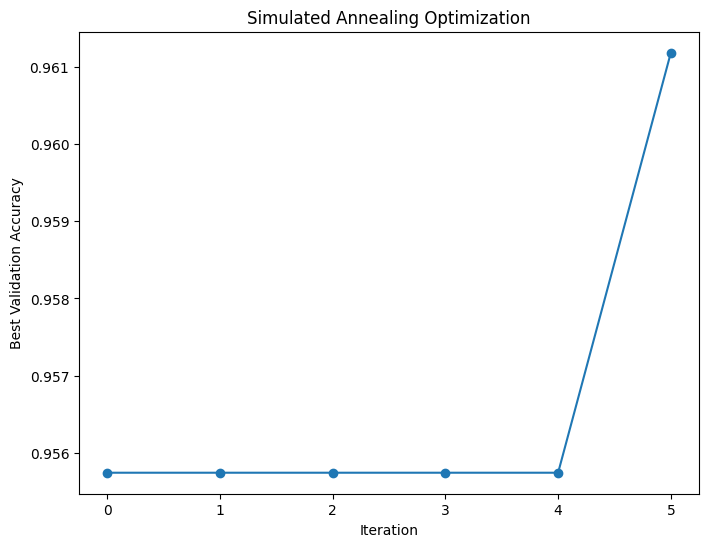

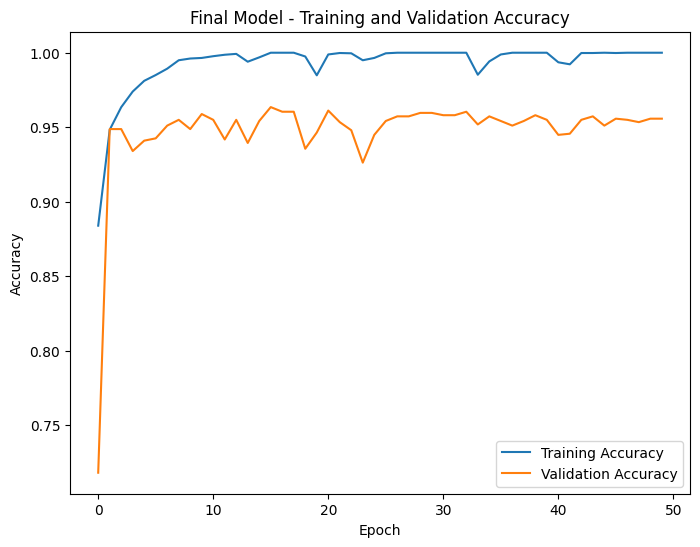

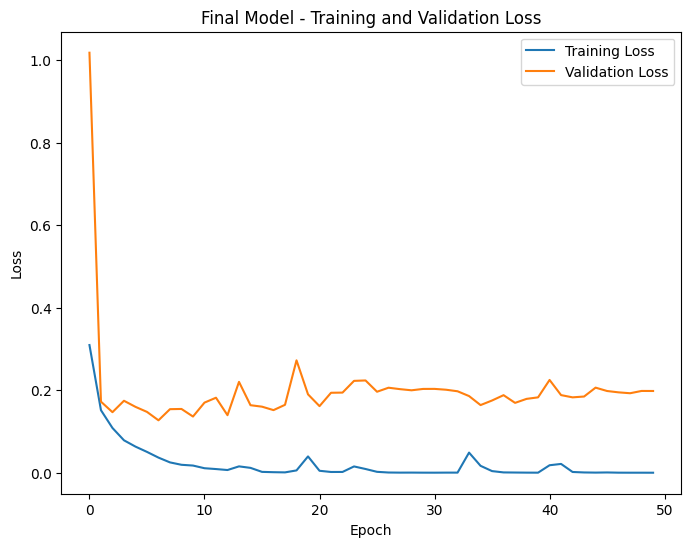

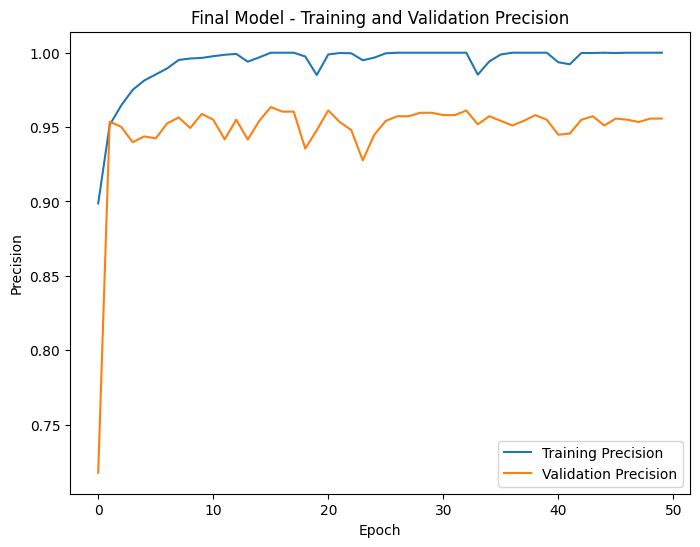

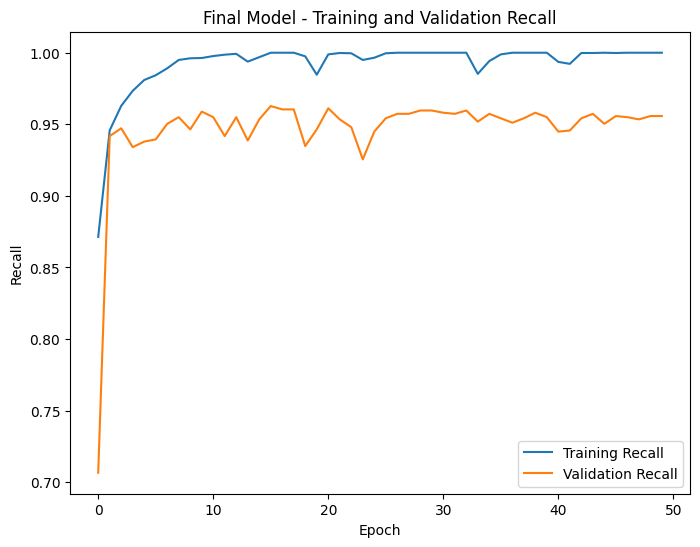

In [48]:
import matplotlib.pyplot as plt

print("\n--- Generating Plots ---")

# Plot 1: SA Optimization History
plt.figure(figsize=(8, 6))
plt.plot(sa_history, marker='o')
plt.title('Simulated Annealing Optimization')
plt.xlabel('Iteration')
plt.ylabel('Best Validation Accuracy')
# plt.clf()  <-- REMOVED

# Plot 2: Final Model Accuracy
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot 3: Final Model Loss
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot 4: Final Model Precision
if 'precision' in final_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['precision'], label='Training Precision')
    plt.plot(final_history.history['val_precision'], label='Validation Precision')
    plt.title('Final Model - Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    # plt.clf()  <-- REMOVED

# Plot 5: Final Model Recall
if 'recall' in final_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['recall'], label='Training Recall')
    plt.plot(final_history.history['val_recall'], label='Validation Recall')
    plt.title('Final Model - Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    # plt.clf()  <-- REMOVED

# All plots will now be displayed in your output cell.

# optimizing COVIDet's hyperparameters using Tabu Search 

In [19]:
search_space = {
    'learning_rate': [1e-5, 1e-3, 1e-5],  # [min, max, step]
    'batch_size':    [8, 64, 8],
    'conv_filters':  [32, 128, 16],
    'n_conv_layers': [4, 10, 2],
    'dense_units_1': [64, 256, 64],
    'dense_units_2': [32, 128, 32],
    'dropout_rate':  [0.0, 0.7, 0.1] 
}

initial_solution = {
    'learning_rate': 0.0001,
    'batch_size': 16,
    'conv_filters': 32,
    'n_conv_layers': 4,
    'dense_units_1': 64,
    'dense_units_2': 32,
    'dropout_rate': 0.1
}

In [20]:
def build_model(params):
    """Builds the Keras model from a param dictionary."""
    inputs = Input(shape=img_shape)

    # Use lowercase keys to match the Tabu Search params
    x = Conv2D(int(params['conv_filters']), (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for i in range(int(params['n_conv_layers'])):
        x = Conv2D(int(params['conv_filters']), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(int(params['dense_units_1']), activation='relu')(x)
    x = Dropout(params['dropout_rate'])(x)
    x = Dense(int(params['dense_units_2']), activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x) 

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
def evaluate_solution(solution_params, X_train, y_train, X_val, y_val, eval_epochs=5, overfit_penalty_factor=0.5):
    print("--- Evaluating: ---")
    pprint.pprint(solution_params)
    
    tf.keras.backend.clear_session()

    try:
        batch_size = int(solution_params['batch_size'])
        learning_rate = float(solution_params['learning_rate'])

        # Create and compile the model using the global builder
        model = build_model(solution_params) # Pass the lowercase params
        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy']) # Only 'accuracy' for speed during search

        print("\nTraining model...")
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=eval_epochs,
            callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)],
            verbose=0 # Set to 0 to keep optimizer log clean
        )

        # Advanced Scoring
        best_val_acc = 0.0
        train_acc_at_best = 0.0
        
        if history.history.get('val_accuracy'): # Use .get() for safety
            best_val_acc = max(history.history['val_accuracy'])
            best_epoch_index = np.argmax(history.history['val_accuracy'])
            train_acc_at_best = history.history['accuracy'][best_epoch_index]
        
        overfit_gap = max(0, train_acc_at_best - best_val_acc)
        score = best_val_acc - (overfit_gap * overfit_penalty_factor)

        print(f"--- Run Finished. Best ValAcc: {best_val_acc:.4f}, TrainAcc: {train_acc_at_best:.4f}, Gap: {overfit_gap:.4f}, Final Score: {score:.4f} ---")
        
        del model
        return score # Return only the score

    except Exception as e:
        print(f"Error evaluating {solution_params}: {e}")
        return 0.0

In [22]:
def get_neighborhood(current_solution, search_space):
    neighbors = []
    for param, (min_val, max_val, step) in search_space.items():
        current_val = current_solution[param]
        # Neighbor by increasing
        neighbor_val_up = current_val + step
        if neighbor_val_up <= max_val:
            neighbor_up = copy.deepcopy(current_solution)
            neighbor_up[param] = neighbor_val_up
            neighbors.append(neighbor_up)
        # Neighbor by decreasing
        neighbor_val_down = current_val - step
        if neighbor_val_down >= min_val:
            neighbor_down = copy.deepcopy(current_solution)
            neighbor_down[param] = neighbor_val_down
            neighbors.append(neighbor_down)
    # Clean up types
    for n in neighbors:
        n['batch_size'] = int(n['batch_size'])
        n['conv_filters'] = int(n['conv_filters'])
        n['n_conv_layers'] = int(n['n_conv_layers'])
        n['dense_units_1'] = int(n['dense_units_1'])
        n['dense_units_2'] = int(n['dense_units_2'])
        n['dropout_rate'] = round(n['dropout_rate'], 2)
        n['learning_rate'] = round(n['learning_rate'], 8)
    return neighbors

In [23]:
def generate_random_solution(search_space):
    print("--- Generating random solution for diversification ---")
    new_solution = {}
    for param, (min_val, max_val, step) in search_space.items():
        if isinstance(step, int) or np.issubdtype(type(step), np.integer):
            num_steps = int((max_val - min_val) / step)
            random_step = random.randint(0, num_steps)
            new_solution[param] = min_val + random_step * step
        else: # Floats
            num_steps = int(round((max_val - min_val) / step))
            random_step = random.randint(0, num_steps)
            new_val = min_val + random_step * step
            new_solution[param] = round(new_val, 8)
    # Ensure correct final types
    new_solution['batch_size'] = int(new_solution['batch_size'])
    new_solution['conv_filters'] = int(new_solution['conv_filters'])
    new_solution['n_conv_layers'] = int(new_solution['n_conv_layers'])
    new_solution['dense_units_1'] = int(new_solution['dense_units_1'])
    new_solution['dense_units_2'] = int(new_solution['dense_units_2'])
    new_solution['dropout_rate'] = float(new_solution['dropout_rate'])
    new_solution['learning_rate'] = float(new_solution['learning_rate'])
    return new_solution

In [24]:
def tabu_search_optimizer(X_train, y_train, X_val, y_val, 
                          initial_solution, search_space, max_iterations, 
                          tabu_size, eval_epochs, max_stuck_iterations=10):
    
    current_solution = initial_solution
    best_solution = current_solution
    iterations_without_improvement = 0
    history_log = [] # ADDED: To log progress for plotting

    print("Evaluating initial solution...")
    best_score = evaluate_solution(best_solution, X_train, y_train, X_val, y_val, eval_epochs)
    print(f"Initial Solution: {current_solution}, Score: {best_score:.4f}")
    history_log.append(best_score)

    tabu_list = deque(maxlen=tabu_size)
    tabu_list.append(frozenset(current_solution.items()))

    for i in range(max_iterations):
        print(f"\n===== Iteration {i+1}/{max_iterations} =====")
        neighborhood = get_neighborhood(current_solution, search_space)
        best_neighbor = None
        best_neighbor_score = -1.0

        for neighbor in neighborhood:
            neighbor_score = evaluate_solution(neighbor, X_train, y_train, X_val, y_val, eval_epochs)
            hashable_neighbor = frozenset(neighbor.items())

            if hashable_neighbor in tabu_list:
                if neighbor_score > best_score: # Aspiration
                    print(f"Aspiration Criteria Met! Tabu solution {neighbor} is new best.")
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
            else:
                if neighbor_score > best_neighbor_score: # Best local move
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score

        if best_neighbor is None:
            print("No valid (or aspirational) neighbors found. Stopping search.")
            break

        current_solution = best_neighbor
        tabu_list.append(frozenset(current_solution.items()))

        if best_neighbor_score > best_score:
            best_solution = best_neighbor
            best_score = best_neighbor_score
            print(f"*** New Global Best Solution Found! Score: {best_score:.4f} ***")
            print(f"*** {best_solution} ***")
            iterations_without_improvement = 0
        else:
            iterations_without_improvement += 1

        print(f"Current Solution: {current_solution}")
        print(f"Best Score so far: {best_score:.4f}")
        print(f"Iterations without improvement: {iterations_without_improvement}")
        history_log.append(best_score) # ADDED: Log best score each iteration

        if iterations_without_improvement >= max_stuck_iterations:
            print(f"\n!!! STUCK for {iterations_without_improvement} iterations. Diversifying...")
            current_solution = generate_random_solution(search_space)
            print(f"Jumping to new random solution: {current_solution}")
            
            new_score = evaluate_solution(current_solution, X_train, y_train, X_val, y_val, eval_epochs)

            if new_score > best_score:
                best_solution = current_solution
                best_score = new_score
                print(f"*** Random jump found a new global best! Score: {best_score:.4f} ***")
            
            iterations_without_improvement = 0
            tabu_list.clear()
            tabu_list.append(frozenset(current_solution.items()))

    print("\n===== Tabu Search Finished =====")
    print(f"Best solution found: {best_solution}")
    print(f"Best score: {best_score:.4f}")
    return best_solution, best_score, history_log # ADDED: Return history_log


In [25]:
MAX_ITERATIONS = 5
TABU_SIZE = 3
EVAL_EPOCHS = 5
MAX_STUCK_ITERATIONS = 5

print("Starting Tabu Search with Diversification...")

best_hyperparams, best_model_score, ts_history = tabu_search_optimizer(
    train_images, train_labels_one_hot, 
    test_images, test_labels_one_hot, 
    initial_solution,
    search_space,
    max_iterations=MAX_ITERATIONS,
    tabu_size=TABU_SIZE,
    eval_epochs=EVAL_EPOCHS,
    max_stuck_iterations=MAX_STUCK_ITERATIONS
)

Starting Tabu Search with Diversification...
Evaluating initial solution...
--- Evaluating: ---
{'batch_size': 16,
 'conv_filters': 32,
 'dense_units_1': 64,
 'dense_units_2': 32,
 'dropout_rate': 0.1,
 'learning_rate': 0.0001,
 'n_conv_layers': 4}
Error evaluating {'learning_rate': 0.0001, 'batch_size': 16, 'conv_filters': 32, 'n_conv_layers': 4, 'dense_units_1': 64, 'dense_units_2': 32, 'dropout_rate': 0.1}: name 'img_shape' is not defined
Initial Solution: {'learning_rate': 0.0001, 'batch_size': 16, 'conv_filters': 32, 'n_conv_layers': 4, 'dense_units_1': 64, 'dense_units_2': 32, 'dropout_rate': 0.1}, Score: 0.0000

===== Iteration 1/5 =====
--- Evaluating: ---
{'batch_size': 16,
 'conv_filters': 32,
 'dense_units_1': 64,
 'dense_units_2': 32,
 'dropout_rate': 0.1,
 'learning_rate': 0.00011,
 'n_conv_layers': 4}
Error evaluating {'learning_rate': 0.00011, 'batch_size': 16, 'conv_filters': 32, 'n_conv_layers': 4, 'dense_units_1': 64, 'dense_units_2': 32, 'dropout_rate': 0.1}: name 'i

In [26]:
print("\n--- Final Results ---")
print(f"Best Score (from search): {best_model_score:.4f}")
print("Best Hyperparameters:")
pprint.pprint(best_hyperparams)


--- Final Results ---
Best Score (from search): 0.0000
Best Hyperparameters:
{'batch_size': 16,
 'conv_filters': 32,
 'dense_units_1': 64,
 'dense_units_2': 32,
 'dropout_rate': 0.1,
 'learning_rate': 0.0001,
 'n_conv_layers': 4}


In [29]:
print("\n--- Training Final Model with Best Parameters ---")
final_model_epochs = 50 
final_batch_size = int(best_hyperparams['batch_size'])

# FIX: Build the final model using the same global function
final_model = build_model(best_hyperparams)

# FIX: Compile with all metrics for final plotting
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate']),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(f"Training final model for {final_model_epochs} epochs...")

final_history = final_model.fit(
    train_images, 
    train_labels_one_hot,
    batch_size=final_batch_size,
    epochs=final_model_epochs,
    validation_split=0.15, # Carve out a new validation split from full data
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)],
    verbose=1
)

print("\n--- Final Model Training Complete ---")
print(final_model.summary())


--- Training Final Model with Best Parameters ---


I0000 00:00:1762024739.485556      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762024739.486456      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training final model for 50 epochs...
Epoch 1/50


I0000 00:00:1762024753.731278     105 service.cc:148] XLA service 0x7b1950089b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762024753.732420     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762024753.732441     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762024754.440869     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/274 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2594 - loss: 1.3948 - precision: 0.2559 - recall: 0.2104

I0000 00:00:1762024759.644563     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.7676 - loss: 0.5730 - precision: 0.7922 - recall: 0.7388 - val_accuracy: 0.6943 - val_loss: 0.9746 - val_precision: 0.6976 - val_recall: 0.6904 - learning_rate: 1.0000e-04
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9278 - loss: 0.2046 - precision: 0.9327 - recall: 0.9234 - val_accuracy: 0.8990 - val_loss: 0.2577 - val_precision: 0.9005 - val_recall: 0.8912 - learning_rate: 1.0000e-04
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9456 - loss: 0.1533 - precision: 0.9493 - recall: 0.9424 - val_accuracy: 0.9547 - val_loss: 0.1409 - val_precision: 0.9570 - val_recall: 0.9508 - learning_rate: 1.0000e-04
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9597 - loss: 0.1215 - precision: 0.9602 - recall: 0.9574 - val_accuracy: 0.9443 - val_loss: 0.1508 - val_precision: 0.9443 - val_recall: 0.9443 - learning_rate: 1.0000e-04
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step -

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 422,731 (1.61 MB)

 Trainable params: 140,803 (550.01 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 281,608 (1.07 MB)

None


In [30]:
test_loss, test_accuracy, test_precision, test_recall = final_model.evaluate(
    test_images, 
    test_labels_one_hot,
    batch_size=final_batch_size
)

print("\n--- Test Results ---")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9529 - loss: 0.1940 - precision: 0.9550 - recall: 0.9529

--- Test Results ---
Test Loss:      0.1972
Test Accuracy:  95.11%
Test Precision: 0.9518
Test Recall:    0.9511



--- Generating Plots ---


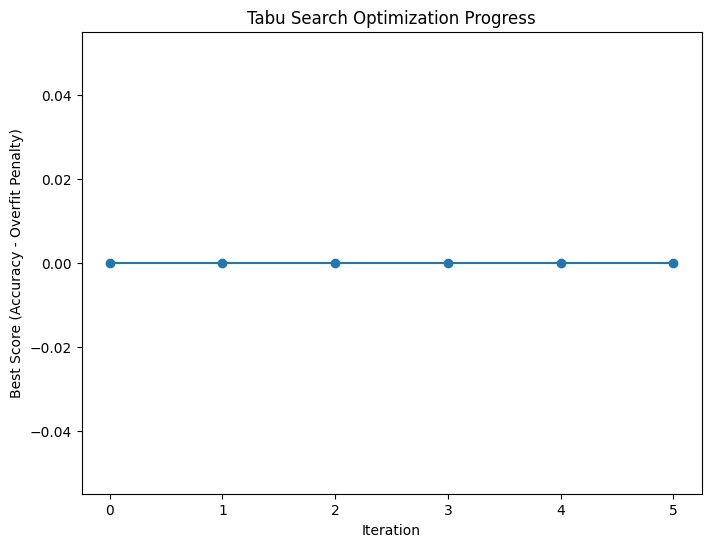

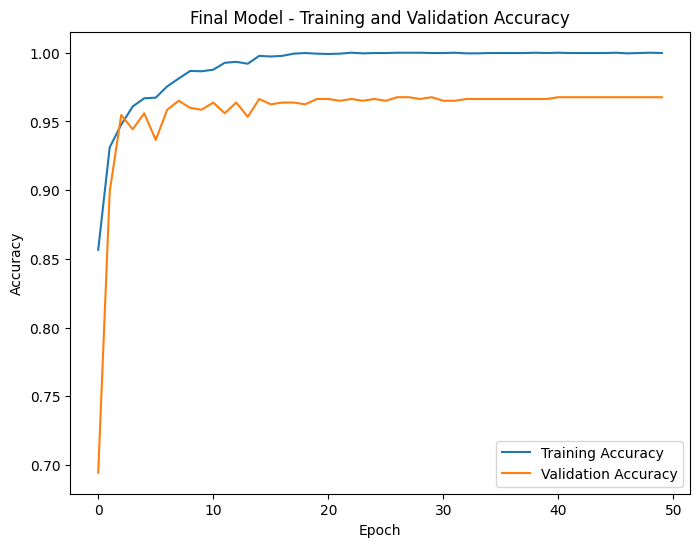

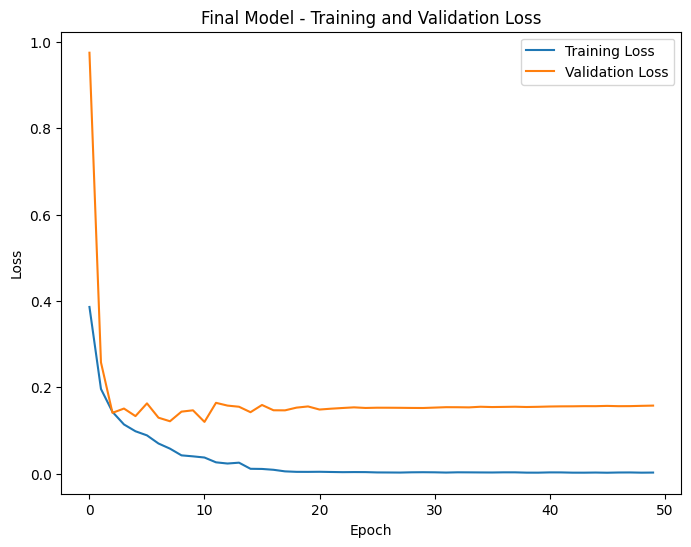

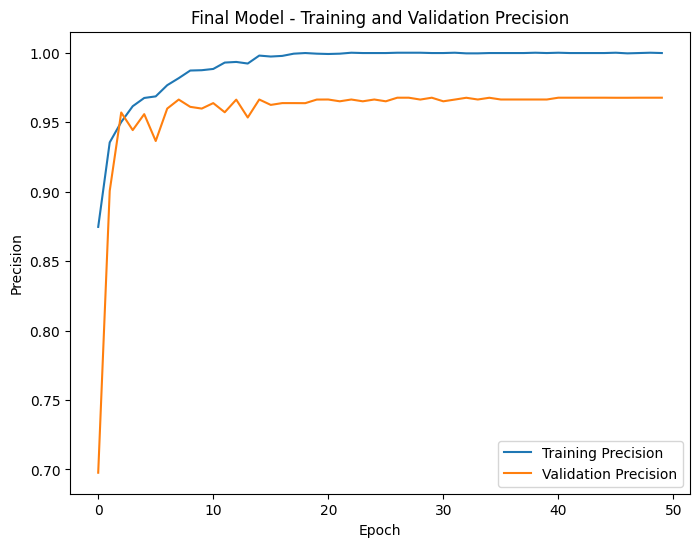

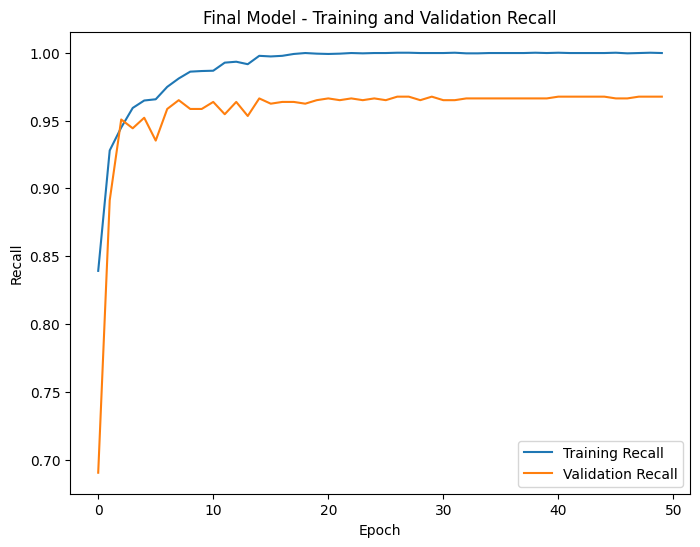

In [32]:
import matplotlib.pyplot as plt

print("\n--- Generating Plots ---")

# Plot 1: Tabu Search Optimization History
plt.figure(figsize=(8, 6))
plt.plot(ts_history, marker='o')
plt.title('Tabu Search Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Best Score (Accuracy - Overfit Penalty)')
# plt.clf()  <-- REMOVED

# Plot 2: Final Model Accuracy
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot 3: Final Model Loss
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.clf()  <-- REMOVED

# Plot 4: Final Model Precision
if 'precision' in final_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['precision'], label='Training Precision')
    plt.plot(final_history.history['val_precision'], label='Validation Precision')
    plt.title('Final Model - Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    # plt.clf()  <-- REMOVED

# Plot 5: Final Model Recall
if 'recall' in final_history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['recall'], label='Training Recall')
    plt.plot(final_history.history['val_recall'], label='Validation Recall')
    plt.title('Final Model - Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    # plt.clf()  <-- REMOVED

# All plots will now display in your output